<h3>Typage et Entrée/Sortie</h3> 

un patient = une liste [durée d'intervention,chirurgien,jour d'opération,durée en sspi réveil et entrée]

on convertit cette liste une une liste de durée sur chaque machine. Il y'a 4 machines.
M0=brancardage, M1=SSPI entrée, M2 = ALR, M3=bloc, M4 = SSPI réveil.

ordo = [[1,3,4,2,3],[1,3,1,4,1],...]
On applique l'algorithme d'ordonnancement : 
    algo(liste de listes de durée) -> (liste de listes de durée)

On applique l'algorithme de lecture : 
    lecture(liste de listes) -> (liste de listes d'horaire de début, liste de listes de durée)

In [2]:
import matplotlib.pyplot as plt

<h3> Fonction de lecture et de calcul de coût </h3>

In [9]:
#La lecture enchaine les opérations au bloc avec 10 minutes d'écarts (Nettoyage du bloc)
#Le principe est de faire en sorte que le brancardage et SSPI d'entrée soit fait pile à tant pour l'opération 

def Lecture(ordo, h0): 
    liste = [[h0-ordo[0][0]-ordo[0][1], h0-ordo[0][1], h0, h0 + ordo[0][2]]]
    n = len(ordo)
    i = 1
    while i < n : 
        tBlocLibre = liste[-1][2] + ordo[i-1][2] + 10 #10 minutes après la fin de l'opération précédente 
        li = [tBlocLibre-ordo[i][0]-ordo[i][1], tBlocLibre-ordo[i][1], tBlocLibre, tBlocLibre+ordo[i][2]]
        liste.append(li)
        i+=1
    return liste
             
# Calcul le cout temporel total (du premier brancardage au dernier réveil en SSPI) 
# et le temps passé en bloc (de h0 à sorti de la dernière opération)
def cout(ordo): 
    liste = Lecture(ordo, 0)
    debutPremierActe = 0 
    finDernierActe = 0 
    ifinal = 0 
    
    for i in range (len(liste)) : 
        debutPremierActe = min(liste[i][0], debutPremierActe)
        finDernierActe = max(liste[i][3]+ordo[i][3], finDernierActe)
            
    coutTotal = finDernierActe - debutPremierActe 
    coutBloc = liste[-1][3] 
    return coutTotal, coutBloc

In [5]:
def diagrammeGantt(ordo):
    starts = Lecture(ordo,25)
    couleurs = ['blue', 'red', 'green', 'yellow', 'black', 'purple', 'pink', 'orange', 'grey', 'brown']  # Couleurs pour les tâches"
    Machines = ["Brancardage", "SSPI Entrée", "Bloc", "SSPI Réveil"]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for indicePatient, patient in enumerate(ordo):
        for i, tempsTache in enumerate(patient):
            ax.barh(f'{Machines[i]}', tempsTache, left=starts[indicePatient][i], color=couleurs[indicePatient])

    ax.set_xlabel('Temps')
    ax.set_ylabel('Machines')
    ax.set_title('Diagramme de Gantt')
    ax.invert_yaxis()  # Inverser l'axe Y pour avoir la machine 1 en haut

    plt.show()

## Générateur d'ensemble de patients 

In [11]:
def Generateur(N): 
    ensemblePatient = []
    for _ in range (N):
        patient = [random.randint(2,30), random.randint(10,30), random.randint(10, 200), random.randint(10,60)]
        ensemblePatient.append(patient)
    
    return ensemblePatient      

<h4>Test de ces fonctions</h4>

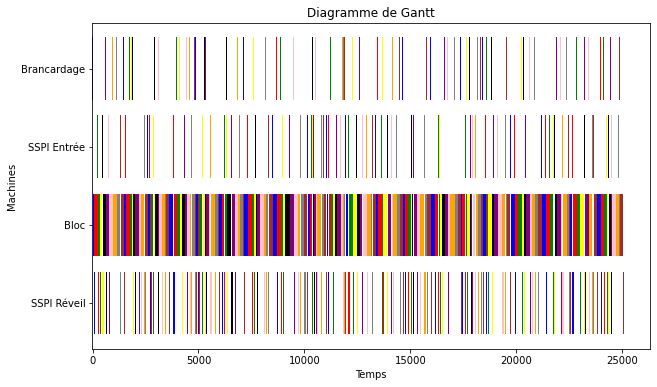

In [8]:
ordo = Generateur(200)
Lecture(ordo, 25)
diagrammeGantt(ordo)

# Algorithme Tabou

In [13]:
def tabou(ordo,nb_voisins=10,nb_iter=50, date = 6):
    liste_tabou=[]
    def genere_voisin(sol):
        sol_copy=sol.copy()
        n1, n2 = np.random.choice(len(sol), 2, replace=False)
        sol_copy[n1],sol_copy[n2]=sol_copy[n2],sol_copy[n1]
        return sol_copy,n1,n2
    k=0
    d = 0 
    while k<nb_iter:
        d+=1
        if d%date == 0 : liste_tabou = []
        k+=1
        liste_voisins=[]
        for i in range (nb_voisins):
            voisin,n1,n2=genere_voisin(ordo)
            liste_voisins.append([voisin,n1,n2])
            liste_voisins.sort(key=lambda x : cout(x[0])[0])
        j=0
        while (liste_voisins[j][1],liste_voisins[j][2]) in liste_tabou and j<len(liste_voisins)-1:
            j+=1
        if j==len(liste_voisins):
            x,y,z=liste_voisins[0]
            liste_tabou.append((z,y))   ### (on ajoute z,y et non pas y,z pour interdire le mouvement inverse)
            ordo=x
        else:
            x,y,z=liste_voisins[j]
            liste_tabou.append((z,y))
            ordo=x

    return ordo
        

# test de l'algo

In [14]:
l=tabou(ordo,20, 150)

print("\n cout : ",cout(l))
print("\n cout : ",cout(ordo))



 cout :  (2424, 2394)

 cout :  (2443, 2394)


# influence des paramètres

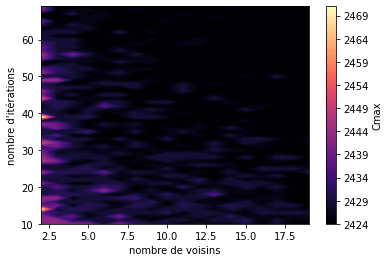

In [15]:
x=np.arange(2,20) ##nombre de voisins
y=np.arange(10,70)  ##nombres d'itérations

X,Y=np.meshgrid(x,y)

def f(x,y):
    return cout(tabou(ordo,x,y))[0]



Z = np.array([[f(x_val, y_val) for x_val in x] for y_val in y])

plt.contourf(X,Y,Z,100,cmap='magma')
cbar=plt.colorbar()
plt.xlabel("nombre de voisins")
plt.ylabel("nombre d'itérations")
cbar.set_label("Cmax")

# Algorithme Génétique 

In [87]:
#Ensemble de fonctions intermédiaires 

def PopulationInitiale(ordo, N): 
    n = len(ordo)
    listeNpermutations = []
    for _ in range (N): 
        ordoPermut = copy.deepcopy(ordo)
        random.shuffle(ordoPermut)
        listeNpermutations.append(ordoPermut)
        
    return listeNpermutations
    
def Selection(population,N): #Selection Forte 
    population.sort(key=lambda x : cout(x)[0])
    print(cout(population[0]))
    return population[:N]

def Selection2(population ,N): #Selection pondérée 
    population.sort(key=lambda x : cout(x)[0])
    print(cout(population[0]))
    selection = []
    CoutMin = cout(population[0])[0]
    i = 0 
    Ninit = len(population)
    while i < Ninit and len(selection)<N: 
        Cout = cout(population[i])[0]
        prob = CoutMin/Cout
        if random.random() < prob : 
            selection.append(population[i])
        i+=1 
    
    while len(selection) < N : 
        selection.append(random.shuffle(population[0]))
    
    return population
      
    
def Croisement(P1, P2): 
    k = len(P1)
    if k <=3 : 
        if random.random()>=0.5 : return P1 
        else : return P2
        
    else : 
        E1 = list.copy(P1)
        E2 = list.copy(P2)
        J = random.randint(0, k-3)
        #récuperation des indices dans E2 correspondants aux gènes échangés avec E1
        ListeIndiceGene = []
        geneManquantE2 = E2[J:J+2]
        geneManquantE2prime = E2[J:J+2]
        
        for j in range (J,J+2):
            gene = E1[j]
            i = 0 
            bool = True
            while i<k and bool : 
                if E2[i] == gene :
                    if J <= i and i <=J+1 :
                        if len(geneManquantE2) > 1 :geneManquantE2.pop(i-J)
                        else : geneManquantE2 = []
                            
                    else : 
                        ListeIndiceGene.append(i)
                    bool = False 
                i+=1
        
        #échange des gènes pour E2 
        E2[J:J+2] = E1[J:J+2]
        for gene in geneManquantE2 : 
            E2[ListeIndiceGene.pop(random.randint(0,len(ListeIndiceGene)-1))] = gene 
            
        #récupération des indices dans E1 correspondants aux gènes échangés avec E2 
        ListeIndiceGene = []
        geneManquantE1 = E1[J:J+2]
        
        for gene in geneManquantE2prime :
            i = 0 
            bool = True
            while i<k and bool : 
                if E1[i] == gene :
                    if J <= i and i <=J+1 :
                        if len(geneManquantE1) > 1 :geneManquantE1.pop(i-J)
                        else : geneManquantE1 = []
 
                    else : 
                        ListeIndiceGene.append(i)
                    bool = False 
                i+=1
                
        #échange des gènes pour E1   

        E1[J:J+2] = geneManquantE2prime
        for gene in geneManquantE1 : 
            E1[ListeIndiceGene.pop(random.randint(0,len(ListeIndiceGene)-1))] = gene 
            
    return E1,E2 



def Mutation(p): 
    j = random.randint(1,len(p)-1) 
    geneJ = p[j]
    p[j] = p[j-1]
    p[j-1]= geneJ
    return p

#Algorithme Final 

def genetique(ordo, N, T, Pcross = 0.6, Pmut = 0.6): #N card de la population (paire)
    t = 0 
    population = PopulationInitiale(ordo,N)
    
    while t < T : 
        #selection des N meilleurs ordonnancements 
        selection = Selection2(population, N)
        
        #regroupement par paire
        paireParIndex = []
        reserve = list(range(N))
        N2 = N//2
        for i in range (N2): 
            coupleI = (reserve.pop(random.randint(0,len(reserve)-1)),reserve.pop(random.randint(0,len(reserve)-1)))
            paireParIndex.append(coupleI)
        
        #Croisements  
        populationIntermediaire = []
        for I in paireParIndex : 
            E1,E2 = Croisement(selection[I[0]], selection[I[1]])
            populationIntermediaire.append(E1)
            populationIntermediaire.append(E2)
            populationIntermediaire.append(selection[I[0]])
            populationIntermediaire.append(selection[I[1]])
                
        
        #Mutations 
        population = []
        for p in populationIntermediaire :
            population.append(Mutation(p))
            population.append(p)
        
        t+=1 
    
    Cmax = cout(population[0])
    index = 0
    for i in range (1,len(population)): 
        CmaxPrime = cout(population[i])
        
        if CmaxPrime < Cmax : 
            Cmax = CmaxPrime
            index = i 
        
    return population[index]

Test de l'algo

In [95]:
ordo = [[10,15,40,30],[10,10,53,15],[5,20,23,40],[20,10,129,10],[10,12,32,28]]
Lecture(ordo, 25)
diagrammeGantt(ordo)

(25076, 25009)

# Algorithme Tabou

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def tabou(ordo,nb_voisins=10,nb_iter=50,d=2):
    p=0
    liste_tabou=[]
    def genere_voisin(sol):
        sol_copy=sol.copy()
        n1, n2 = np.random.choice(len(sol), 2, replace=False)
        sol_copy[n1],sol_copy[n2]=sol_copy[n2],sol_copy[n1]
        return sol_copy,n1,n2
    k=0
    while k<nb_iter:
        p+=1
        if p%2==0:
            liste_tabou=[]
        k+=1
        liste_voisins=[]
        for i in range (nb_voisins):
            voisin,n1,n2=genere_voisin(ordo)
            liste_voisins.append([voisin,n1,n2])
            liste_voisins.sort(key=lambda x : cout(x[0])[0])
        j=0
        while (liste_voisins[j][1],liste_voisins[j][2]) in liste_tabou and j<len(liste_voisins)-1:
            j+=1
        if j==len(liste_voisins):
            x,y,z=liste_voisins[0]
            liste_tabou.append((z,y))   ### (on ajoute z,y et non pas y,z pour interdire le mouvement inverse)
            ordo=x
        else:
            x,y,z=liste_voisins[j]
            liste_tabou.append((z,y))
            ordo=x
    return ordo

        

# test de l'algo

In [10]:
l=tabou(ordo,10,50)


print("nouvel ordo",l,"cout : ",cout(l))
print("ancien ordo",ordo,"cout : ",cout(ordo))


nouvel ordo [[10, 10, 53, 15], [5, 20, 23, 40], [10, 12, 32, 28], [10, 15, 40, 30], [20, 10, 129, 10]] cout :  (347, 317)
ancien ordo [[10, 15, 40, 30], [10, 10, 53, 15], [5, 20, 23, 40], [20, 10, 129, 10], [10, 12, 32, 28]] cout :  (370, 317)


# influence des paramètres

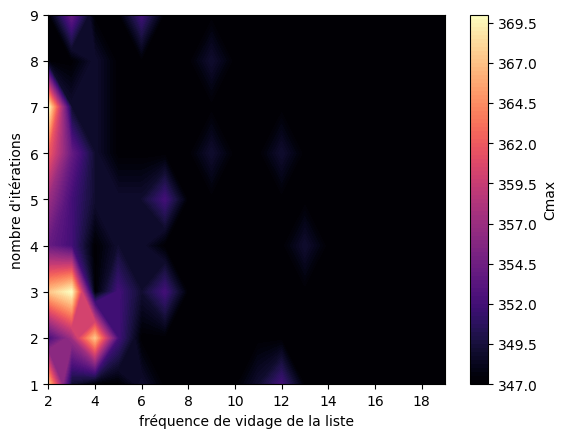

In [12]:
x=np.arange(2,20) ##nombre de voisins
y=np.arange(1,10)  ##nombres d'itérations

X,Y=np.meshgrid(x,y)

def f(x,y):
    return cout(tabou(ordo,x,50,y))[0]



Z = np.array([[f(x_val, y_val) for x_val in x] for y_val in y])

plt.contourf(X,Y,Z,100,cmap='magma')
cbar=plt.colorbar()
plt.xlabel("fréquence de vidage de la liste")
plt.ylabel("nombre d'itérations")
cbar.set_label("Cmax")

In [114]:
NewOrdo = genetique(ordo,2,100)

(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25067, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25009)
(25049, 25

In [99]:
cout(NewOrdo)

(25044, 25009)